In [1]:
import os
import numpy as np
import keras
import math
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from kapre.utils import Normalization2D
from keras.models import Sequential
from keras.layers import *
from keras import backend as k
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.preprocessing import sequence
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
train_feat = np.load('train_feat.npy')
val_feat = np.load('val_feat.npy')
test_feat = np.load('test_feat.npy')

ytrain = np.load('ytrain.npy')
yval = np.load('yval.npy')
ytest = np.load('ytest.npy')

In [4]:
features_dim = 98
wide = 40
N1 = 128
N2 = 1
Nfc1 = 60
out_dim = 35
BATCH_SIZE = 128

In [5]:
model = Sequential()

model.add(Normalization2D(int_axis = 1, input_shape=(features_dim, wide, 1)))

model.add(Permute((2, 1, 3)))

model.add(Conv2D(N1, kernel_size = (1, 2), strides = (1, 2), activation = 'relu'))

model.add(BatchNormalization(axis = -1, scale = None))
    
model.add(MaxPooling2D(pool_size = 2, strides = 1))
    
model.add(Conv2D(N2, kernel_size = (1, 2), strides = (1, 2), activation = 'relu'))

model.add(BatchNormalization(axis = -1, scale = None))
    
model.add(MaxPooling2D(pool_size = 2, strides = 1))

model.add(Lambda(lambda q: K.squeeze(q, -1)))

model.add(Bidirectional(CuDNNLSTM(32, return_sequences = True)))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(Nfc1, activation = 'relu'))

model.add(Dropout(0.2))

model.add(Dense(out_dim, activation = 'softmax'))

adam_ = optimizers.Adam(lr = 1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam_, metrics = ['categorical_accuracy'])

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization2d_1 (Normaliza (None, 98, 40, 1)         0         
_________________________________________________________________
permute_1 (Permute)          (None, 40, 98, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 49, 128)       384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 49, 128)       384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 48, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 24, 1)         257       
_________________________________________________________________
batch_normalization_2 (Batch (None, 39, 24, 1)         3         
__________

In [8]:
batches = int(len(train_feat)/BATCH_SIZE)

In [9]:
def batch_generator():
    
    while True:

        for batch in range(batches):
            
            x_ = []
            data = train_feat[batch * BATCH_SIZE: (batch + 1) * BATCH_SIZE]
            label = ytrain[batch * BATCH_SIZE: (batch + 1) * BATCH_SIZE]
            
            for i in data:
                x_.append(np.reshape(i, (features_dim, wide, 1)))
                 
            x = np.asarray(x_)
            yield (x, label)

In [10]:
x_val = []

for i in range(len(val_feat)):
    x_val.append(np.reshape(val_feat[i], (features_dim, wide, 1)))
    
valx = np.asarray(x_val)

In [11]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate

In [12]:
lrate = LearningRateScheduler(step_decay)

In [13]:
checkpointer = ModelCheckpoint(filepath='checkpoint_asr.h5', monitor='val_categorical_accuracy', save_best_only=True)

In [14]:
earlystopper = EarlyStopping(monitor='val_categorical_accuracy', patience=10, verbose=1)

In [15]:
history = model.fit_generator(batch_generator(), steps_per_epoch = batches, epochs = 500, validation_data=(valx, yval), 
                              callbacks=[checkpointer, earlystopper, lrate], shuffle = True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
Changing learning rate to 0.001
662/662 [==============================] - 24s 36ms/step - loss: 2.6828 - categorical_accuracy: 0.2495 - val_loss: 2.0095 - val_categorical_accuracy: 0.4326
Epoch 2/500
Changing learning rate to 0.001
662/662 [==============================] - 22s 34ms/step - loss: 2.0434 - categorical_accuracy: 0.4116 - val_loss: 1.6852 - val_categorical_accuracy: 0.5262
Epoch 3/500
Changing learning rate to 0.001
662/662 [==============================] - 22s 34ms/step - loss: 1.7625 - categorical_accuracy: 0.4860 - val_loss: 1.4405 - val_categorical_accuracy: 0.5950
Epoch 4/500
Changing learning rate to 0.001
662/662 [==============================] - 22s 33ms/step - loss: 1.5752 - categorical_accuracy: 0.5381 - val_loss: 1.2767 - val_categorical_accuracy: 0.6383
Epoch 5/500
Changing learning rate to 0.001
662/662 [==============================] - 22s 34ms/step - loss: 1.4544 - categorical_accuracy: 0.5715 -

662/662 [==============================] - 22s 34ms/step - loss: 0.9200 - categorical_accuracy: 0.7180 - val_loss: 0.8738 - val_categorical_accuracy: 0.7422
Epoch 39/500
Changing learning rate to 6.400000000000001e-05
662/662 [==============================] - 22s 34ms/step - loss: 0.9216 - categorical_accuracy: 0.7168 - val_loss: 0.8745 - val_categorical_accuracy: 0.7430
Epoch 40/500
Changing learning rate to 4e-05
662/662 [==============================] - 22s 34ms/step - loss: 0.9176 - categorical_accuracy: 0.7175 - val_loss: 0.8693 - val_categorical_accuracy: 0.7455
Epoch 41/500
Changing learning rate to 4e-05
662/662 [==============================] - 22s 34ms/step - loss: 0.9170 - categorical_accuracy: 0.7190 - val_loss: 0.8689 - val_categorical_accuracy: 0.7451
Epoch 42/500
Changing learning rate to 4e-05
662/662 [==============================] - 22s 33ms/step - loss: 0.9119 - categorical_accuracy: 0.7208 - val_loss: 0.8730 - val_categorical_accuracy: 0.7431
Epoch 43/500
Changi

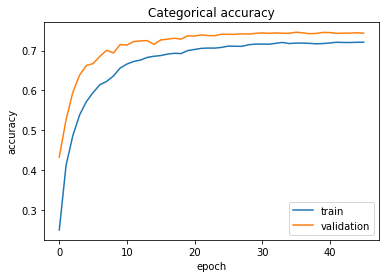

In [16]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

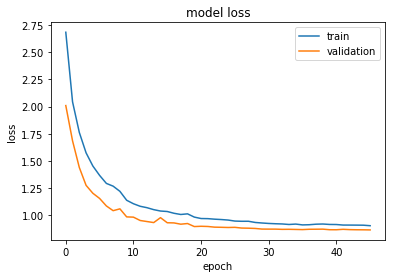

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [18]:
testEval = model.evaluate(np.reshape(test_feat, (len(test_feat), features_dim, wide, 1)), ytest, batch_size = BATCH_SIZE)

11005/11005 [==============================] - 1s 92us/step


In [19]:
print('Evaluation scores: \nMetrics: {} \nTest: {}'.format(model.metrics_names, testEval))

Evaluation scores: 
Metrics: ['loss', 'categorical_accuracy'] 
Test: [1.0363783510150502, 0.695411177062815]


In [20]:
ROOT_DIR = os.path.normpath(os.path.join(os.path.dirname(os.path.realpath('__file__'))))
DATA_INFO = os.path.join(ROOT_DIR, 'data_asr', 'data_info')

In [21]:
test_files = pd.read_csv(os.path.join(DATA_INFO, 'testing_list.txt'), sep = ' ', header = None)[0].tolist()

In [22]:
test_lab = [os.path.dirname(i) for i in test_files]

In [23]:
lab = LabelEncoder()

test_encode = lab.fit_transform(test_lab)

In [24]:
y_pred = model.predict(np.reshape(test_feat, (len(test_feat), features_dim, wide, 1)), verbose=1)

11005/11005 [==============================] - 2s 144us/step


In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.figure(figsize=(25,25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=11,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    plt.tight_layout()

In [26]:
classes = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 
          'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 
          'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
          'two', 'up', 'visual', 'wow', 'yes', 'zero']

In [27]:
cm = confusion_matrix(test_encode, np.argmax(y_pred, 1))

Normalized confusion matrix


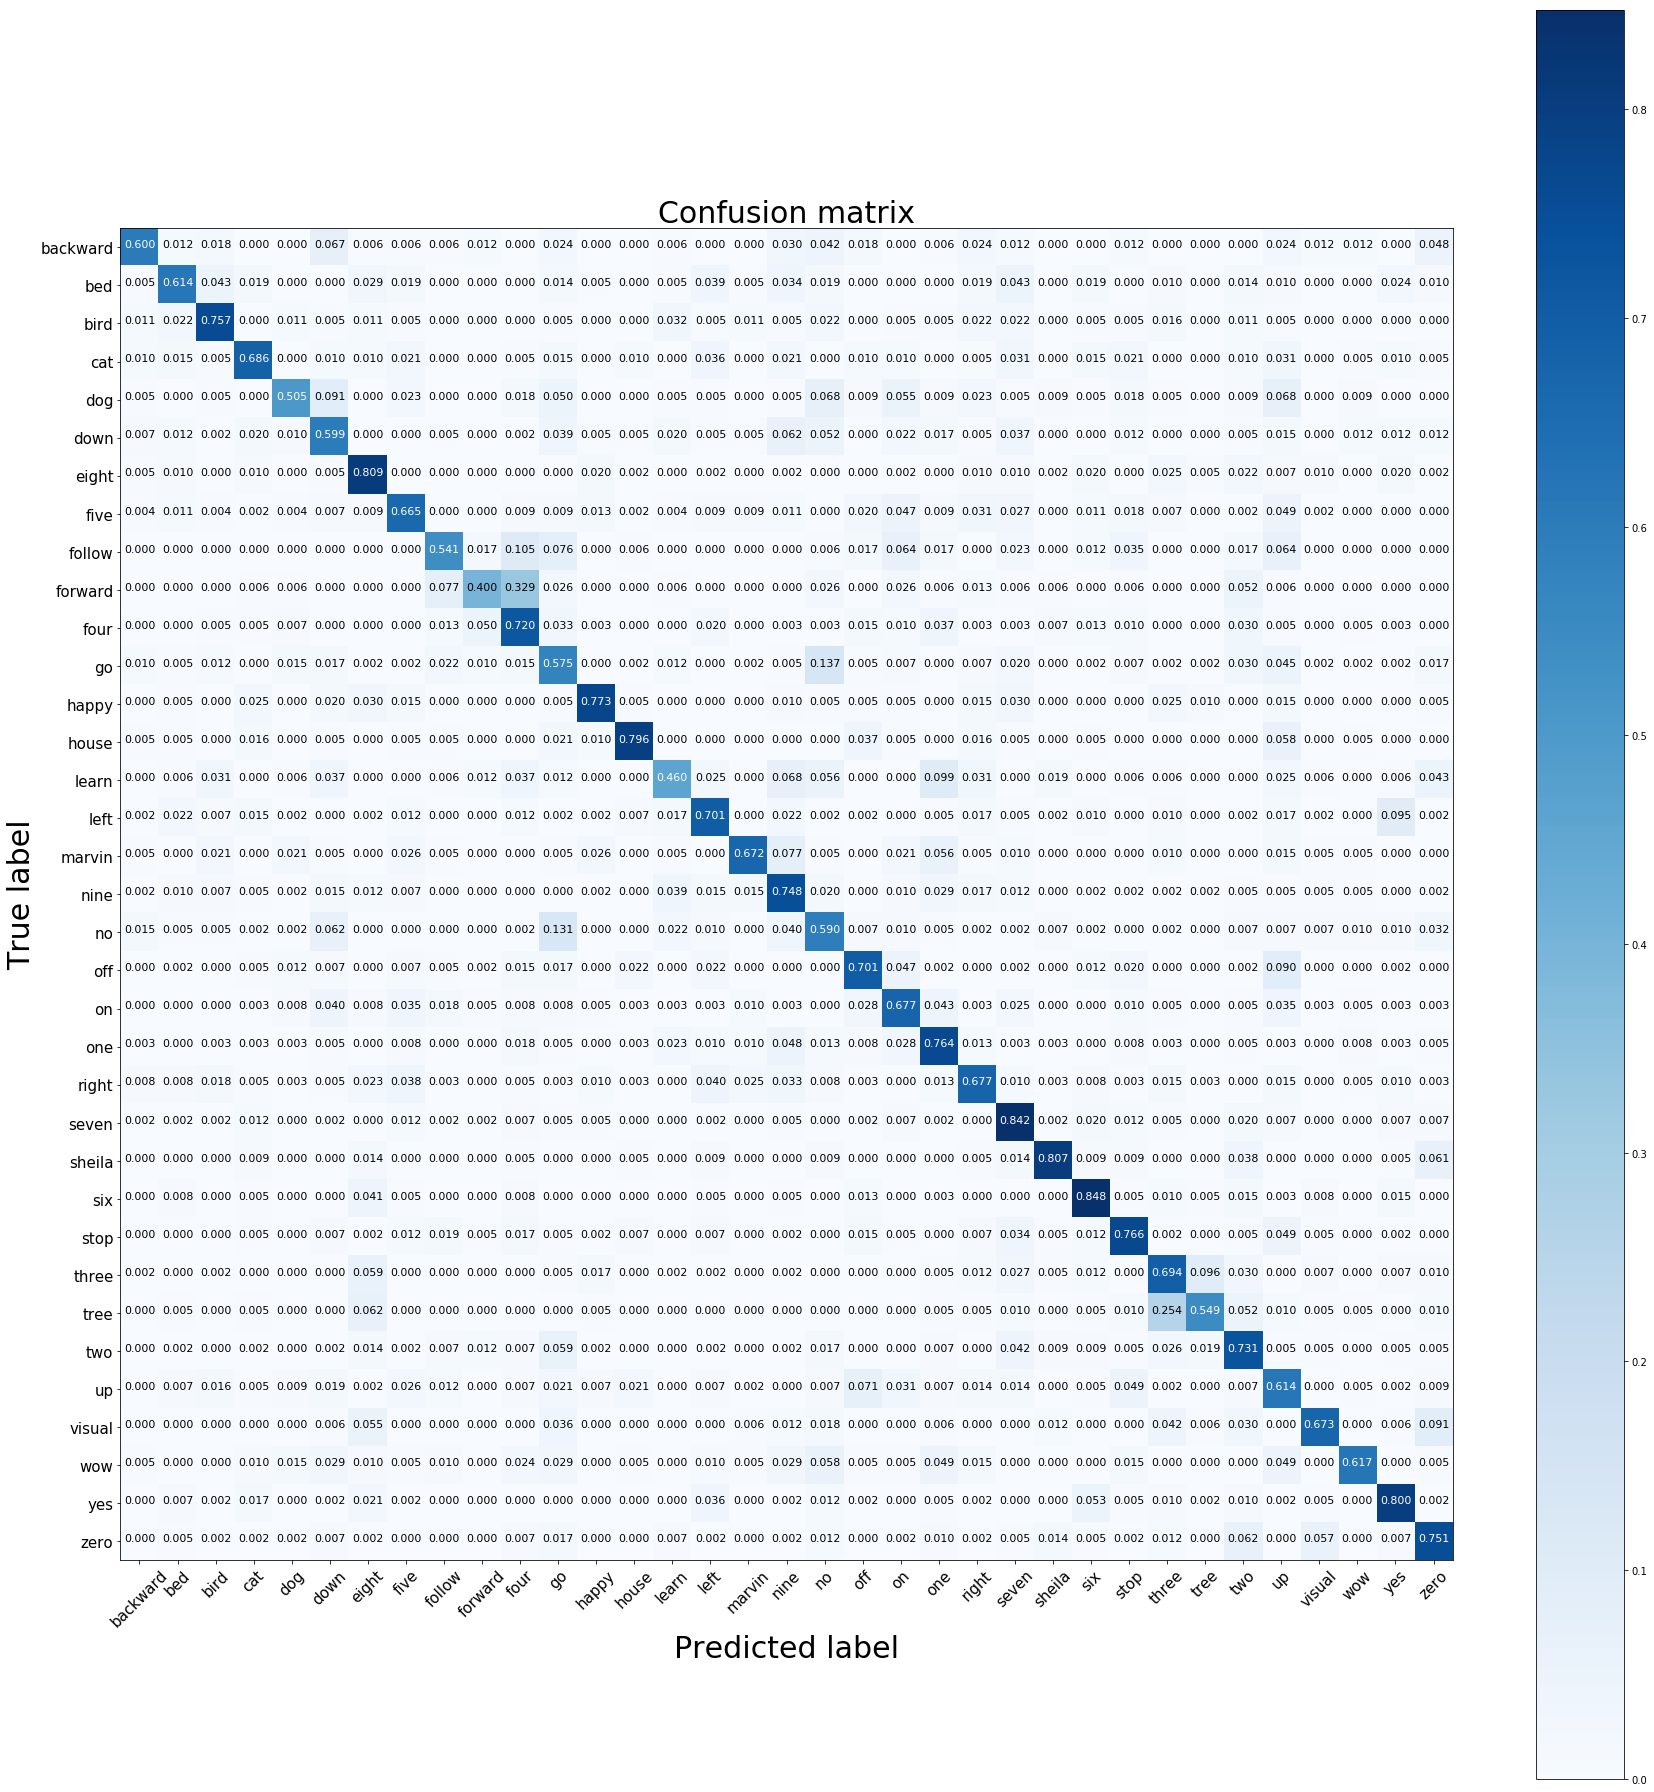

In [28]:
plot_confusion_matrix(cm, classes, normalize=True)

In [29]:
print(classification_report(test_encode, np.argmax(y_pred, 1), target_names = classes))

              precision    recall  f1-score   support

    backward       0.74      0.60      0.66       165
         bed       0.68      0.61      0.64       207
        bird       0.70      0.76      0.73       185
         cat       0.66      0.69      0.67       194
         dog       0.72      0.50      0.59       220
        down       0.64      0.60      0.62       406
       eight       0.73      0.81      0.77       408
        five       0.76      0.67      0.71       445
      follow       0.60      0.54      0.57       172
     forward       0.60      0.40      0.48       155
        four       0.67      0.72      0.69       400
          go       0.53      0.57      0.55       402
       happy       0.77      0.77      0.77       203
       house       0.80      0.80      0.80       191
       learn       0.51      0.46      0.48       161
        left       0.73      0.70      0.72       412
      marvin       0.78      0.67      0.72       195
        nine       0.66    